# Programming Assignment 3: Clustering


<ins>Background/Intuition:<ins>

As we progress into the age of digital information, the amount of data available for us to work with is staggering. You can peruse a billion images through google search, or query millions of songs with Spotify's API. However, while this data is in abundance, **labels** for it are usually a lot harder to come by. Suppose you wanted to group songs into subjective categories of 'chill and relaxing' versus 'upbeat and energetic'.

You might process these songs and generate some potentially relevant quantifiers, say the average pitch of the song (lower = more bass, higher = more treble) and its average amplitude (lower = quieter, higher = louder). 

| Song | Average Pitch | Average Amplitude |
| --- | --- | --- |
| Typhoons, Royal Blood  | -18.1 | 19.6 |
| Waltz No. 2, Shostakovich | -7.6 | 11.2 |
| Sandstorm, Darude | 16.2 | 18.6 |
| ... | ... | ... |
<font size="1">Note: Not real data</font>

But unless you're willing to pay some music-appreciators a lot of money to listen to and review every song (of potentially millions of songs), there's no easy way to get definitive labels of 'relaxing' versus 'upbeat' for this data. Instead we turn towards **unsupervised** learning.
    
If we can cluster these songs into groups of similar pitch and amplitudes, even without labels we might be able to learn a lot about their distribution. We could listen to five or six songs from a cluster of thousands to get a good understanding of what kind of music it represents. And if we have a labeled song, maybe your favorite upbeat track for when you're at the gym, we can look at what cluster it gets put into and explore if the other songs in the cluster are also good upbeat tracks for the gym (this is not unlike the way real music services give you recommendations based off your listening habits).
    
Now that we've hopefully sold you on the excitement of unsupervised clustering, let's write our own k-means implementation and run it on some real data.
    
<ins>Format of this PA:<ins>
1. Debugging Practice
2. K-Means Helper Functions
3. Run K-Means on Simulated Data
4. Run K-Means on MNIST Image Data

### ACT 1: Before We Make Code, We Un-Break Code

#### 1A: Sums and Prods
In the code below, we are trying to sum the columns of `X`, and then matrix multiply them with `y` to produce `Q` similar to the example below:

$$
X = 
\begin{bmatrix}
    x_{11} & x_{12} \\
    x_{21} & x_{22}
\end{bmatrix}, \quad
y = 
\begin{bmatrix}
    y_{1} \\
    y_{2}
\end{bmatrix}
$$

$$
Q = 
\begin{bmatrix}
    x_{11} + x_{12} \\
    x_{21} + x_{22}
\end{bmatrix} 
\begin{bmatrix}
    y_{1} & y_{2}
\end{bmatrix}
=
\begin{bmatrix}
    (x_{11} + x_{12})y_{1} & (x_{11} + x_{12})y_{2} \\
    (x_{21} + x_{22})y_{1} & (x_{21} + x_{22})y_{2}
\end{bmatrix} 
$$


In [ ]:
import numpy as np

X = np.array([[1,2,3],
              [4,5,6],
              [7,8,9]])
y = np.array([[0, 2, 1]])

def broken_sum_prod(X, y):
    X_sum = np.sum(X, axis=1)

    Q = X_sum @ y
    return Q
    

But when we run this code, all we get is a `ValueError`, seems something went wrong with our dimensions.

In [ ]:
broken_sum_prod(X,y)

Investigate the shape of `X_sum` and see if you can find an argument in the documentation of [np.sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html) that can fix this error.

In [ ]:
# ACT 1A: fix this code
def fixed_sum_prod(X, y):
    X_sum = np.sum(X, axis=1).reshape((3,1))
    Q = X_sum @ y
    return Q

In [248]:
fixed_sum_prod(X,y)

array([[ 0,  6,  3],
       [ 0, 18,  9],
       [ 0, 30, 15]])

#### 1B: Take A Long Axis
It's often best to correct errors before we make them. Later in this assignment we will be interested in using the function [np.take_along_axis](https://numpy.org/doc/stable/reference/generated/numpy.take_along_axis.html) to extract elements at desired indices from a matrix. You might want to familiarize yourself with its documentation before proceeding.

Here we attempt to use `indices` to index into `arr` to retrieve the values `[[1],[6],[8]]`; the 0th, 2nd, and 1st values in the respective rows.

In [210]:
arr = np.array([[1,2,3],
              [4,5,6],
              [7,8,9]])
indices = np.array([0, 2, 1])

In [ ]:
np.take_along_axis(arr, indices, axis=1)

We appear to have ran into a dimension error, lets look at the shapes of `arr` and `indices` and investigate.

In [212]:
print(arr.shape)
print(indices.shape)

(3, 3)
(3,)


Looking back at the documentation we spot that for the `indices` variable there's a descriptor `"This must match the dimension of arr, but dimensions Ni and Nj only need to broadcast against arr."`. Though the latter part sounds cryptic, the beginning (`must match the dimension of arr`) is pretty clear. Our `arr` is two dimensional and our `indices` are a 1D vector, let's try fixing that.

In [213]:
indices = np.array([[0, 2, 1]])

In [214]:
np.take_along_axis(arr, indices, axis=1)

array([[1, 3, 2],
       [4, 6, 5],
       [7, 9, 8]])

Hmm, this is strange; we seem to be taking the 0th **and** the 2nd **and** the 1st element of each row, something still isn't right. See if you can figure out what's going on, and get the function call to return just `[[1],[6],[8]]`.

In [249]:
# ACT 1B: fix this code
indices = np.array([[0], [2], [1]])
np.take_along_axis(arr, indices, axis=1)

array([[1],
       [6],
       [8]])

What was the error? Do we now have a better understanding of `dimensions Ni and Nj only need to broadcast against arr`? (think about how the dimensions of `indices` affect the output)

#### <span style='color:cyan'>  Your answer here: We needed the indices to cast at each row</span>

---

## Clustering Overview

In this assignment we'll implement k-means clustering. Let's call our input data $X$, the cluster centers $W$, and the number of clusters $k$. Each row of $X$ is a data point, each row of $W$ is the coordinates of a cluster center (a centroid). The goal of this algorithm is to minimize the distance between every data point and its closest centroid.

In this k-means implementation, our loss is **the mean of square euclidean distances** between each point and its closest centroid. More precisely, if our centroids are $\mathbf{w}_1, \ldots, \mathbf{w}_k$ and our points are $\mathbf{x}_1, \ldots, \mathbf{x}_n$, then our loss (averaged over n points) is:
$$\frac{1}{n}\sum_{i=1}^n \min_j ||\mathbf{x}_i - \mathbf{w}_j||^2, $$

where the $\min_j$ just means we incur loss only to the closest centroid $j$, and discard the distance to any centroids that aren't $j$.  

As we saw in lecture this objective can also be written as:
$$
\frac{1}{n}\sum_{j=1}^{k} \sum_{i \in C_{j}}\left\|\mathbf{x}_i - \mathbf{w}_j\right\|^{2}
$$
Where $C_j$ is the set of points belonging to cluster $j$, and $k$ is again the total number of clusters.

**Note:** This loss is **not exactly the same** as the one covered in lecture, which minimized the sum of square distances rather than the mean. We opt to use the mean of the distances so that we can later compare training and validation losses for different numbers of datapoints. 

  
To implement this in code, you will create a method to compute pairwise distances between data points and centroids, along with a method that re-estimates the centroids after each step. We'll need a way to associate which point belongs to which centroid (which we'll achieve through a method `associate()`), and lastly a method to randomly initialize the centroids.


---

# Implementing K-means

### ACT 2: Step-by-step for `compute_sq_dists`

For `compute_sq_dists`, your goal is to find the squared distance between each point and each centroid. We ultimately want a 2-D array where the $(i, j)$-th entry is the squared distance between $\mathbf{x}_i$ and $\mathbf{w}_j$. **Looping through each example in X is too slow, so we'll do this with vectorized Numpy operations**. <p>

Let $\mathbf{x}_i$ and $\mathbf{w}_j$ be the $i$-th and $j$-th rows of $X$ and $W$ respectively. We'd like to find the squared distance between each point and each cluster centroid: this helps compute the square loss, and to find the closest centroid we will just choose the centroid with the smallest square distance. Now, a cool math trick! It turns out that:
    
$$||\mathbf{x}_i - \mathbf{w}_j||^2 = ||\mathbf{x}_i||^2 + ||\mathbf{w}_j||^2 - 2\mathbf{x}_i\cdot \mathbf{w}_j$$

To find the squared distance between each point and each centroid, first we compute the squared norm of each row of X (corresponding to $||\mathbf{x}_i||^2$ in the above equation) and the squared norm of each row in W ($||\mathbf{w}_j||^2$). We can make a matrix where the $(i,j)$-th entry is $||\mathbf{x}_i||^2 + ||\mathbf{w}_j||^2$ by summing a column of X's row-norms with a row of W's row-norms. Recall that python + Numpy will automatically perform [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html) if one is a column vector and the other a row vector. <p>

To find $\mathbf{x\cdot w}$, we multiply $\mathsf{X W^T}$, which results in an array where the in
$(i, j)$-th entry equals $\mathbf{x}_i\cdot\mathbf{w}_j$, the inner product of the $i$-th row of X
with the $j$-th row of W. <p>
    
*Reminder: no for loops.*

In [250]:
#ACT 2 squared distance_matrix.  Use the trick described above to compute the distance matrix using vectorization.
def compute_sq_dists(X, W):
    '''
    Inputs: 
    X is a 2-D Numpy array of shape (n, d), each row is a data point
    W is a 2-D Numpy array of shape (k, d), each row is a cluster centroid

    Output:
    2-D Numpy array of shape (n, k) where the i,j-th entry represents the squared euclidean distance 
    from the ith row of X to the jth row of W. 
    '''
    Xnorm = np.sum(X**2, axis = 1, keepdims = True)
    Wnorm = np.sum(W**2, axis = 1, keepdims = True)
    sq_dists1  = (Xnorm  + np.transpose(Wnorm))
    sq_dists = sq_dists1 - (2 *(X@np.transpose(W)))
    
    return sq_dists

### ACT 3: Tips for `update_centroids`

Given data points `X` and vector `assoc`, an array of length `n` with containing values ranging from `0` to `k` which indicates which data point is *associated* to what cluster, our goal is to return a matrix of `k` new centroids, where the value of each centroid is the mean of its associated points.

Using the notation from lecture, the new centroid location for points belonging to cluster $C_j$ is:

$$
 \mathbf{w}_j = \overline{\mathrm{x}}\left(\mathrm{C}_{\mathrm{j}}\right)=\frac{1}{\mathrm{~m}_{\mathrm{j}}} \sum_{\mathrm{i} \in \mathrm{C}_{\mathrm{j}}}  \mathbf{x}_i \quad\left(\mathrm{m}_{\mathrm{j}}=\left|\mathrm{C}_{\mathrm{j}}\right|\right)
$$


In this act (**and only in this act**) it is okay to loop over `k`, the number of clusters, as this can reduce the complexity of the code. You're still encouraged to solve this without loops, and cannot loop over the number of data points `n` as this will grow prohibitively slow for large `n`.

</font>

In [251]:
#ACT 3 Implement update_centroids, computing the means of our most recent clusters
def update_centroids(X, k, assoc):
    '''
    Inputs: 
    X is a 2-D Numpy array of shape (n, d), each row is a data point
    k is the number of clusters
    assoc is a 1-D array of size n indicating the center closest to each point

    Output:
    A 2-D array of cluster centroids size (k,d), where each row is a centroid.
    If there are no points associated with a cluster, this should return 
    all zeros for that row/cluster.
    '''
       
    # your code here
    W = np.zeros((k, X.shape[1]))
     
    for i in range (0,k):
        xrange = len(X[assoc == i])
        summ = np.sum(X[assoc == i],axis =0)
        if(xrange == 0):
            W[i] = 0 
        else: 
            W[i] = summ/xrange
    return W

### Act 4: Find centers associated with each data point given distances from each point to each center.
In `associate_centroids` we will find which centroid each data point is closest to, and also return the loss for convenience. W should first compute the square distances to each point, using a function we defined above, then use that to create the `assoc` vector as defined above/below. This can then be used to compactly estimate our overall loss (copied here for convenience, **reminder**: this is not exactly the lecture loss, we're taking the average over the number of points $n$ here).

$$
\frac{1}{n}\sum_{j=1}^{k} \sum_{i \in C_{j}}\left\|x^{i}-\bar{x}\left(C_{j}\right)\right\|^{2}
$$

For computing the loss, you might need [np.take_along_axis](https://numpy.org/doc/stable/reference/generated/numpy.take_along_axis.html) from earlier.  
**Hint:** see also [np.expand_dims](https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html) and [np.squeeze](https://numpy.org/doc/stable/reference/generated/numpy.squeeze.html).

In [252]:
#ACT 4 Using the distance matrix find centers associated with each point and compute loss
def associate_centroids(X, W):
    '''
    Inputs:
    X is a 2-D Numpy array of shape (n, d), each row is a data point
    W is a 2-D Numpy array of shape (k, d), each row is a cluster centroid

    Output:
    (loss, assoc) where 
    assoc is a 1-D array of size n indicating the center closest to each point
    loss is the average loss of the data from those associations.
    '''
    
    #### ACT 4A Compute the *indices* `assoc` corresponding to minimum entry in each row of dists
    
    # your code here
    sq_dists = compute_sq_dists(X,W)
    assoc = np.argmin(sq_dists, axis = 1)

    ###   ACT4B ### Use `assoc` to get values from X and calculate loss
    calloss = np.take_along_axis(sq_dists, assoc[:, None], axis = 1)
    loss = np.mean(calloss)
    
    return loss, assoc

### Act 5: Implement random initialization of centroid

To start running k-means we need starting points to use as centroids. Use [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) to select `k` random data points from `X` to use as initial centroids. We want to make sure our selected initialization points are *unique*, i.e. we don't accidentally pick the same point twice; [np.random.choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) should have an argument that guarantees this.

In [253]:
# ACT 5 random initialization
def rand_init(X,k):
    '''
    Inputs: 
    X is a 2-D Numpy array of shape (n, d), each row is a data point
    k is the number of clusters
    Outputs:
    C a 2-D Numpy array of shape (k, d) of random points at which to initialise centroids
    '''
    
    # your code here
    C = X[np.random.choice(X.shape[0], k, replace = False), :]
    return C

### Act 6: Putting everything together.  

Implement the main iteration loop, alternating between associating data points to their nearest center, and estimating new centers. Remember to keep track of the loss at each iteration, and add an epsilon stopping criterion (if the loss hasn't decreased by more than epsilon since the previous iteration -- proportional to the current loss -- break the loop).

For more clarification, your stopping criterion should for iteration $t$ check if:
$$
\frac{\mathrm{loss}_{t-1} - \mathrm{loss}_{t}}{\mathrm{loss}_{t}} \lt \epsilon
$$

In [254]:
# ACT 6 implement the K-means loop
def k_means(X, k, max_iters=50, eps=1e-5):
    '''
    Perform k-means clusting on X using k clusters, running for max_iters loops,
    and stop early if loss decreases by a proportion less than eps.  
    Early stopping does not occur before epoch 2.

    Output (W, loss) the final centers W and the last iteration's loss
    '''
    
    # your code here
    losst = np.zeros(max_iters)
    W = rand_init(X,k)
    for i in range(max_iters):
        losst[i], assoc = associate_centroids(X,W)
        loss = losst[i]
        func = (losst[i-1] - losst[i])/losst[i]
        if(i > 0 and func < eps):
            break
        W = update_centroids(X,k,assoc)
    
    return W, loss

---
### K-means Scatter Plot Helper Function
  
**This has been written for you.** <p>

* Read the code and understand it from a high-level point of view. <br>
* Understand how to call this function

In [255]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh
np.random.seed(324)

# Purpose:
# --------
# Plot d-dimensional sample in 2D with cluster indicators (uses PCA to lower dimension from d to 2)
#
# How to call:
# ------------
# X is the examples: each row is an example
# C is a 1-d array of associated centroid index (integers):
#    Each entry in C corresponds to a row in X, so len(C) = X.shape[0]
#    OR
#    C = [] means only data visualization w/o centroids
#
#
# Additional paramters (do not change unless instructed):
# bb is the bounding box
# `colors` indicates the colors: the default colors the 
#     first cluster `b` or blue, next cluster `g` or green, etc.
# 
def plot_sample(X, C, bb=[], ms=10, colors='bgrcmk'):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)

    from itertools import cycle
    if X.shape[1] > 2:
        err_str = "X contains {}-dimensional points. Data points must be 2-dimensional.".format(X.shape[1])
        raise Exception(err_str)
    if len(C) == 0: C = np.ones(X.shape[0])
    k = int(C.max()) + 1
    if bb != []:
        plt.xlim(bb[0]), plt.ylim(bb[1])
    cycol = cycle(colors)
    for i in range(k):
        ind = C == i
        col = next(cycol)
        plt.scatter(X[ind,0], X[ind,1], s=ms, c=col)
    plt.show()

## Experimenting With Synthetic Data

Now that we've implemented k-means clustering, let's run an experiment on simulated data.  
First let's visualize the data (something you should get in the habit of):

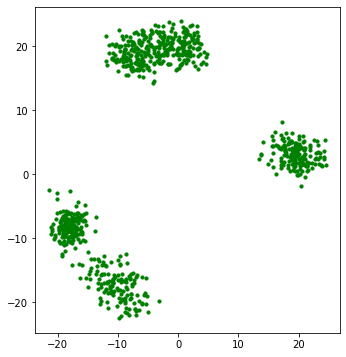

In [256]:
Xt = np.load("simulated_data.npy")
N = len(Xt) # number of samples
split = int(0.8*N) # keep 80% for train, 20% for val

Xt_train = Xt[0:split,:]
Xt_val= Xt[split:,:]
_ = plot_sample(Xt_train, [])

How many clusters does it look like the data can/should be split into? Why did you pick that number?  
(Optional, what could these clusters be if these points corresponded to our song data as described at the start?)

#### <span style='color:cyan'>  Your answer here: WE see 3 distinct groupings so i think splitting into 3 is the right way to go  </span> 

### ACT 7: running k-means on simulated data
Run your k-means function on the training data `Xt_train`, report the loss vector and use `plot_sample` to plot the clusters.  
**Run each cell multiple times to see how the random initialization changes the final clusters.**  
**Name your vector of associated centroids** `assoc`**, this will be relevant later**

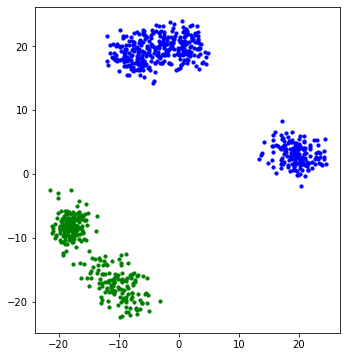

In [257]:
# ACT7a: Run k-means clustering on Xt_train, using k = 2 clusters
W, loss = k_means(Xt_train, 2)
loss1, assoc = associate_centroids(Xt_train, W)
z = plot_sample(Xt_train, assoc)
# your code here

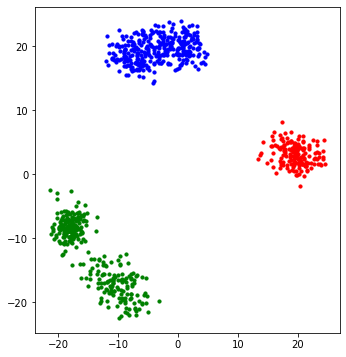

In [258]:
# ACT7b: Run k-means clustering on Xt_train, using k = 3 clusters
W, loss = k_means(Xt_train, 3)
lossb, assoc = associate_centroids(Xt_train, W)
z = plot_sample(Xt_train, assoc)
# your code here

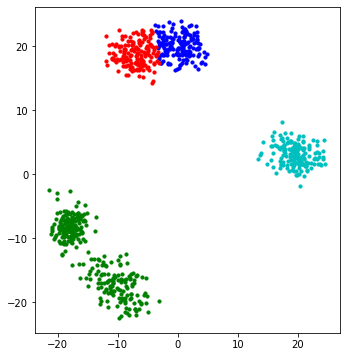

In [259]:
# ACT7c: Run k-means clustering on Xt_train, using k = 4 clusters
# you might need to run this one several times to get the `expected` clusters
W, loss = k_means(Xt_train, 4)
lossc, assoc = associate_centroids(Xt_train, W)
z = plot_sample(Xt_train, assoc)
# your code here

### ACT 8: Loss Curves
Let's look at how our final loss changes as a function of `k`, the cluster count (i.e. let's see those elbow curves). For each `k` value in the range of `1,...,20` run k-means `20` times (to average out the variability from the initialization). Record the mean training and validation loss for each set of runs.

Finally, make a **well-labeled** plot of training and validation losses versus `k`.

**Hint:** you should never be running `k_means` on the validation dataset, *another function* you defined above can return you the validation loss given the centroid locations you learned from the training set

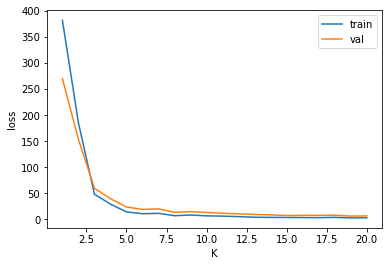

In [260]:
# Act8: build elbow curve of train + val losses
# Warning, this code should take 20-30 seconds to run; if it's taking forever, you probably didn't 
# vectorize your k-means code correctly (remember, no for loops over the data points)

# your code here
import matplotlib.pyplot as plt
loss_tr = [0]*20
loss_t = [0]*20
train_mean = [0]*20
val_mean = [0]*20


k = np.array([i+1 for i in range(20)])
for i in range(len(k)): 
    for j in range(len(k)):
        W, loss_tr[j] = k_means(Xt_train, k[i])
        loss_t[j], assoc = associate_centroids(Xt_val, W)
    train_mean[i] = sum(loss_tr)/len(loss_tr)
    val_mean[i] = sum(loss_t)/len(loss_t)     
plt.xlabel("K")
plt.ylabel("loss")
plt.plot(k, train_mean)
plt.plot(k, val_mean)
plt.legend(["train","val"])

Around how many clusters do we see the *elbow* in the loss curve (look back to the lecture slides if you need a reminder on what the elbow is).  
Does this make sense given your previous observations on the distribution of the data?

#### <span style='color:cyan'>  Your answer here: 3 clusters in the loss curve is valid since there is three distinct groups of points </span>

It looks like we can minimize both the validation and training loss by taking more and more clusters. Why would this be a bad idea in practice? Does having a ton of clusters likely **reduce** or **increase** our ability to infer useful information from the data?

## Experimenting With MNIST Data

Now that we understand some of the behavior of K-means for our simulated dataset, let's see how this extends to images of digits.

In [261]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

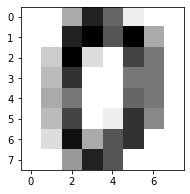

In [262]:
#Load the digits dataset
digits = load_digits()

#Display the first digit
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [263]:
# load digits zero and one
X_digits, y_digits = load_digits(n_class=2, return_X_y=True)
Xt = scale(X_digits)
N = len(Xt)
split = int(0.8*N) # keep 80% for train, 20% for val

Xt_train = Xt[0:split,:]
Xt_val= Xt[split:,:]

In [264]:
# use PCA to reduce the data dimension to 2 for plotting
reduced_data = PCA(n_components=2).fit_transform(Xt_train)

Let's visualize this PCA-reduced data:

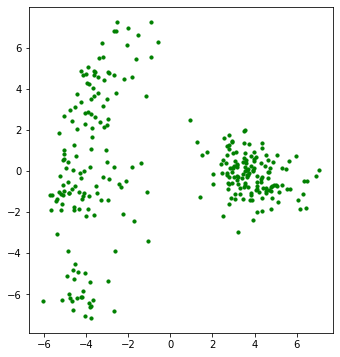

In [265]:
_ = plot_sample(reduced_data, [])

Does this data look *clusterable*? How many clusters do we expect? Why does this make sense given the data we loaded above?

#### <span style='color:cyan'>  Your answer here:Yes it does, I think two since our input was 2D or 1 and 0s </span>

### ACT 9: K-means on MNIST data
Run your k-means clustering code on this data and plot the clusters.

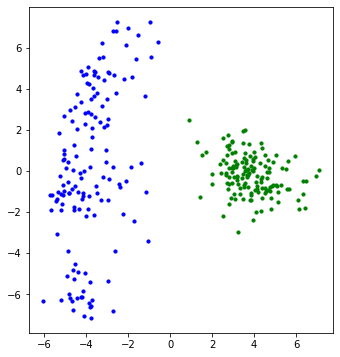

In [266]:
# ACT9: Run k-means on MNIST data with k=2

# your code here
W, loss = k_means(Xt_train, 2)
loss9, assoc = associate_centroids(Xt_train, W)

reduced_data = PCA(n_components=2).fit_transform(Xt_train)

z = plot_sample(reduced_data, assoc)

Lets plot some representative samples from this clustering:

In [267]:
cluster_0 = Xt_train[np.where(assoc==0)]
cluster_1 = Xt_train[np.where(assoc==1)]

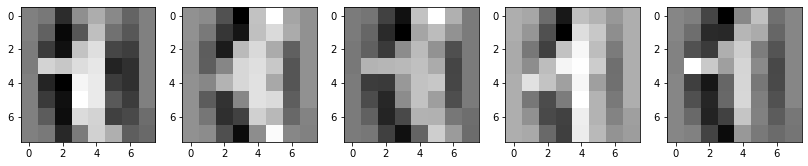

In [268]:
fig, axs = plt.subplots(1, 5)
fig.set_size_inches(14,14)
for i, ax in enumerate(axs):
    ax.imshow(cluster_0[i].reshape(8,8), cmap="gray")

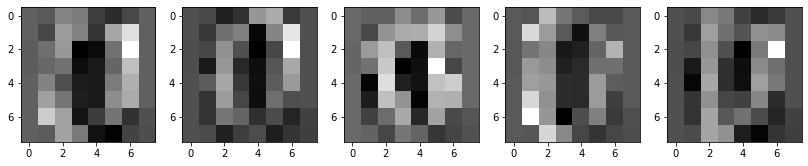

In [269]:
fig, axs = plt.subplots(1, 5)
fig.set_size_inches(14,14)
for i, ax in enumerate(axs):
    ax.imshow(cluster_1[i].reshape(8,8), cmap="gray")

Do the images in each cluster look similar? If the code is working correctly they hopefully should!  
Note that the zero-th cluster might not correspond to the digit zero. If you were to use this system for digit classification, you'd manually have to look at some representatives of each cluster before, label them yourself, and then apply those labels to the rest of the data based on which cluster they belong to (this is still a lot more efficient than manually labeling a thousand numbers though).

### ACT 10: More Elbow Curves
Copy your code from ACT 8, and plot train and validation loss curves for this MNIST data.

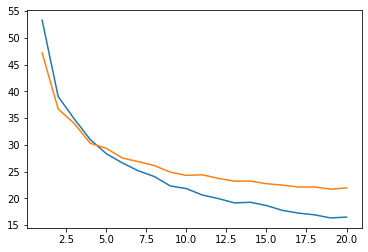

In [270]:
# Act10: build elbow curve of train + val losses

import matplotlib.pyplot as plt
train_mean = [0]*20
val_mean = [0]*20
loss_train = [0]*20
loss_test = [0]*20

k = np.array([i+1 for i in range(20)])
for i in range(len(k)):
    for j in range(len(k)):
        W, loss_train[j] = k_means(Xt_train, k[i])
        loss_test[j], assoc = associate_centroids(Xt_val, W)

    train_mean[i] = sum(loss_train)/len(loss_train)
    val_mean[i] = sum(loss_test)/len(loss_test)
plt.plot(k, train_mean)
plt.plot(k, val_mean)

Do the loss curves above go down as the number of clusters increase? Despite this, why would it make no sense to pick a large value of K for an application like digit classification?

#### <span style='color:cyan'>  Your answer here: AS cluster number increase the loss curve goes down, picking a large amount wont work here due to the fact that we have a limited number of digits and the number of K cluster is in correlation with that. Therefore, limited pixels means limited k-clusters. </span> 